# `StableSpectralElements.jl` - 2D Euler vortex example using entropy-stable  discretization

First, let's load the packages used in this example.

In [35]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs, StaticArrays, BenchmarkTools

We will be solving the two-dimensional compressible Euler equations, which are a hyperbolic system of conservation laws given by
$$
\begin{aligned}
\partial_t \rho(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) &= 0,\\
\partial_t ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t)) + \nabla_{\boldsymbol{x}} \cdot ( \rho(\boldsymbol{x},t) \boldsymbol{V}(\boldsymbol{x},t) \otimes \boldsymbol{V}(\boldsymbol{x},t) + P(\boldsymbol{x},t)\boldsymbol{I}) &= \boldsymbol{0},\\
\partial_t E(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot ((E(\boldsymbol{x},t) + P(\boldsymbol{x},t))\boldsymbol{V}(\boldsymbol{x},t)) &= 0,
\end{aligned}
$$
with 
$$
 P(\boldsymbol{x},t) = (\gamma - 1)\big(E(\boldsymbol{x},t) - \tfrac{1}{2} \rho(\boldsymbol{x},t) \lVert \boldsymbol{V}(\boldsymbol{x},t) \rVert^2 \big),
$$
where $\gamma = 1.4$ is the specific heat ratio. The initial condition is an isentropic vortex in a uniform flow on the domain $\Omega = (0,1)^2$ with periodic boundary conditions, at a  Mach number of 0.4. The density field is shown below.

![620x400](figures/euler_initial_condition.png)

In [36]:
mach_number = 0.4
angle = 0.0
L = 1.0
γ=1.4
T = L/mach_number # end time
strength = sqrt(2/(γ-1)*(1-0.75^(γ-1))) # for central value of ρ=0.75

conservation_law = EulerEquations{2}(γ)
exact_solution = IsentropicVortex(conservation_law, θ=angle,
    Ma=mach_number, β=strength, R=1.0/10.0, x_0=(L/2,L/2));

Let's discretize the above problem using a `ModalMulti` discretization of degree $p = 3$ on an isoparametrically warped triangular mesh with $M = 4$ edges in each direction. We will use an entropy-stable flux-differencing scheme employing [Ranocha's two-point flux](https://link.springer.com/chapter/10.1007/978-3-030-39647-3_42) and Lax-Friedrichs interface dissipation; to obtain an entropy-conservative scheme, one can instead take `inviscid_numerical_flux=EntropyConservativeNumericalFlux()`. The modal (i.e. non-collocated) formulation necessitates the introduction of an "entropy projection" procedure as well as a facet correction equivalent to the use of hybridized/decoupled SBP operators as proposed by [Chan (2018)](https://arxiv.org/abs/1708.01243).

In [37]:
p = 3
M = 4

form = FluxDifferencingForm(inviscid_numerical_flux=EntropyConservativeNumericalFlux(), 
    entropy_projection=true, facet_correction=true)

reference_approximation = ReferenceApproximation(ModalTensor(p), 
    Tri(), mapping_degree=p, N_plot=25)

uniform_mesh = uniform_periodic_mesh(reference_approximation, ((0.0,L),(0.0,L)), (M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, ChanWarping(1/16, (L,L)))

spatial_discretization = SpatialDiscretization(mesh, reference_approximation, project_jacobian=true)

results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
    "results/euler_vortex_2d/", overwrite=true, clear=true);

ode = semidiscretize(conservation_law, spatial_discretization, 
    exact_solution, form, (0.0, T), parallelism=Serial());

We'll now plot the mesh, showing the tensor-product quadrature nodes.

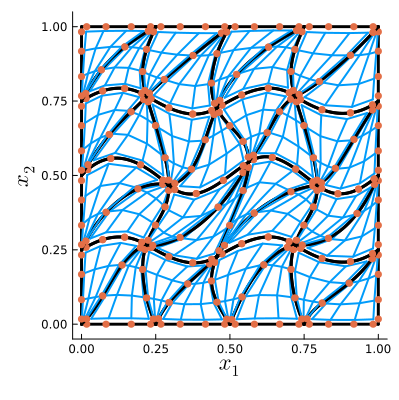

In [38]:
plot(spatial_discretization, grid_connect=true, fmt=:png)

The resulting system of ordinary differential equations can then be solved as usual using OrdinaryDiffEq.jl's `solve` function.

In [39]:
dt = T/1000
reset_timer!()
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=true), adaptive=false, dt=dt,
        save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            4.37s /  98.4%           1.07GiB /  97.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual    5.05k    4.30s  100.0%   851μs   1.05GiB  100.0%   218KiB
   time deriv.           162k    2.24s   52.1%  13.9μs    488MiB   45.4%  3.09KiB
   nodal values          162k    1.78s   41.3%  11.0μs    587MiB   54.6%  3.72KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each conservative variable (i.e. $\rho$, $\rho V_1$, $\rho V_2$, and $E$) can be computed as follows.

In [40]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T))

L2 error:
[0.03737399796802688, 0.0756689507398657, 0.06101338814451275, 0.07058026706282318]


We'll check that the scheme is indeed conservative by plotting the evolution of the integrated conservative variables.

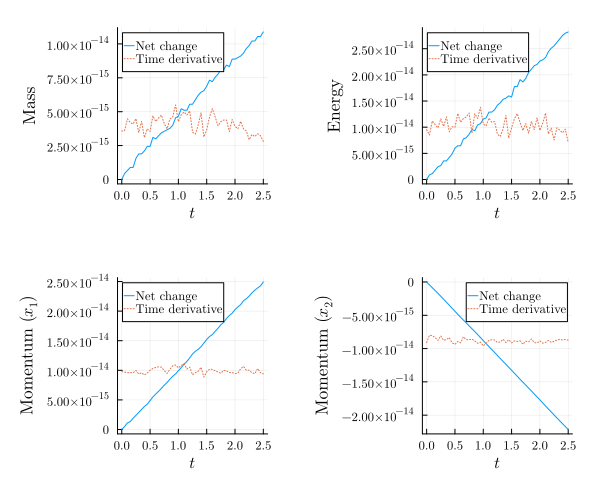

In [41]:
conservation = analyze(PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization),
    load_time_steps(results_path))

mass = plot(conservation, ylabel="Mass", 1)
xmom = plot(conservation, ylabel="Momentum (\$x_1\$)", 2)
ymom = plot(conservation, ylabel="Momentum (\$x_2\$)", 3)
energy = plot(conservation, ylabel="Energy", 4)

plot(mass, energy, xmom, ymom, size=(600,500), margin=5mm, fmt=:png)

We can finally plot the evolution of the integrated mathematical entropy $\int_{\Omega} S(U(\boldsymbol{x},t)) \, \mathrm{d} \boldsymbol{x}$, where $S(U(\boldsymbol{x},t)) = - \tfrac{1}{1-\gamma}\rho(\boldsymbol{x},t) \ln(p(\boldsymbol{x},t)/\rho(\boldsymbol{x},t)^\gamma) $, again using the scheme's collocated LGL quadrature rule. Notice that the scheme dissipates entropy, as expected.

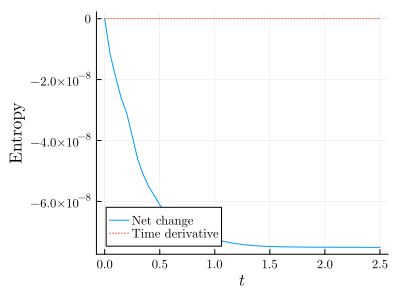

In [42]:
entropy_analysis = EntropyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
entropy_results = analyze(entropy_analysis, load_time_steps(results_path))
entropy = plot(entropy_results, ylabel="Entropy", size=(400,300), fmt=:png)

We can now visualize the density field as a `.vtu` file, for example, in ParaView.

In [43]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization, string(results_path,
        "solution_",i,".vtu"), sol.u[i], variable_name="Density")
end

In [44]:
uq = vcat([1.0 1.0 1.0 5.0], rand(size(ode.p.operators.Vᵀ,1),4))
u = @view uq[1,:]
d = 2
wq = rand(size(ode.p.operators.Vᵀ,1),4)
w = @view wq[1,:] 
@btime @views conservative_to_entropy!($w, $conservation_law,$u)

  40.279 ns (0 allocations: 0 bytes)


In [45]:
copyto!(w,u)

4-element view(::Matrix{Float64}, 1, :) with eltype Float64:
 1.0
 1.0
 1.0
 5.0